# Run Machine Learning Inference on the NPU with Pytorch and ONNX


## Goals

* Introduce the Ryzen™ AI Software Platform

* Show the ONNX model generation and inference flow on the NPU
    
* Deploy a quantized ResNet-50 model onto Ryzen AI NPU for inference
      
## References

**[Ryzen AI Software Platform](https://ryzenai.docs.amd.com/en/latest/getstartex.html)**

**[Vitis AI Execution Provider](https://onnxruntime.ai/docs/execution-providers/Vitis-AI-ExecutionProvider.html)**

**[Matplotlib Gallery](https://matplotlib.org/stable/gallery/axes_grid1/simple_axesgrid.html)**

**[CIFAR10](https://github.com/EN10/CIFAR)**

**[Confusion Matrix](https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7)**

---


## Ryzen AI Software Platform

The AMD Ryzen™ AI Software Platform enables developers to take machine learning models trained in PyTorch or TensorFlow and run them on laptops powered by Ryzen AI. The Ryzen AI software platform intelligently optimizes tasks and workloads, freeing-up CPU and GPU resources, and ensuring optimal performance at lower power. The diagram below shows the flow from trained models to execution.

<center>
    <img src="./images/png/raisw13.png" alt="sdk" style="max-height: 400px; width:auto; height:auto;">
</center>
<center><strong>Ryzen AI software platform</strong></center>


---


## Step 1: Import Packages

Run the following cell to import all the necessary packages to be able to run the inference in the Ryzen AI NPU.

In [1]:
# Computer Vision and Image Processing Libraries
import cv2

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid

In [16]:
# Torch and torchvision libraries
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import CIFAR10

In [16]:
# ONNX and Quantization Libraries
import onnx
import onnxruntime
from onnxruntime.quantization.calibrate import CalibrationDataReader
from onnxruntime.quantization import CalibrationDataReader, QuantType, QuantFormat, CalibrationMethod, quantize_static
from quark.onnx.quantization.config import Config, get_default_config
from quark.onnx import ModelQuantizer

In [3]:
# General Libraries
import enum
import numpy as np
import pickle
import os
import glob
import tarfile
import urllib.request

In [16]:
# Data Science and Metrics Libraries
import pandas as pd
import seaborn as sn
from sklearn.metrics import accuracy_score, confusion_matrix

---

## Step 2: Prepare the Data

We are going to use a pre-trained ResNet-50 model from PyTorch Hub for the CIFAR-10 dataset.   

### Download the CIFAR-10 dataset

Execute the following cells to download the CIFAR-10 dataset. The dataset is stored in `data/cifar-10-batches-py/`. 

In [4]:
global models_dir, data_dir
models_dir = ".\\onnx"
data_dir= ".\\onnx\\data"

In [5]:
# License 1 (see end of notebook)

# Download data - One-time only

datadirname = ".\\onnx\\data"
if not os.path.exists(datadirname):
   data_download_tar = "cifar-10-python.tar.gz"
   urllib.request.urlretrieve("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz", data_download_tar)
   file = tarfile.open(data_download_tar)
   # file.extractall(data_dir)
   file.close()

# # Delete cifar-10-python.tar.gz source file after all images are extracted
# data_images_path = os.path.join(os.getcwd(), "cifar-10-python.tar.gz")
# files = glob.glob(data_images_path)
# for f in files:
#     os.remove(f)

The [CIFAR-10](https://github.com/EN10/CIFAR) dataset has 60,000 32x32 pixels color images in 10 classes, each class consists of 6,000 images.
There are 50,000 training images and 10,000 test images.   
The dataset contains five training batches and one test batch, 10,000 images in each. Each class in the test batch has 1,000 randomly selected images.

<div class="alert alert-box alert-info">
For inference we use the 10,000 test images.
</div>

The CIFAR10 classes are enumerated in the `Cifar10Classes` class below:

In [19]:
class Cifar10Classes(enum.Enum):
    airplane = 0
    automobile = 1
    bird = 2
    cat = 3
    deer = 4
    dog = 5
    frog = 6
    horse = 7
    ship = 8
    truck = 9

Run the following two cells to display a subset of the test images.

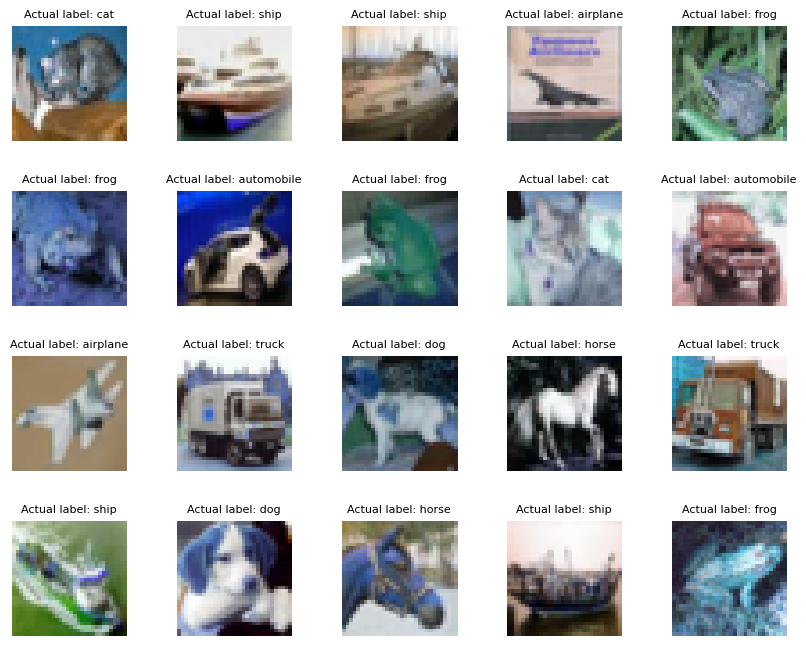

In [20]:
# License 2 (see end of notebook)

def unpickle(file):
    with open(file,'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

datafile = r'./onnx/data/cifar-10-batches-py/test_batch'
metafile = r'./onnx/data/cifar-10-batches-py/batches.meta'

test_batch = unpickle(datafile) 
metadata = unpickle(metafile)

images = test_batch['data']
labels = test_batch['labels']
images = np.reshape(images,(10000, 3, 32, 32))

im = []

dirname = 'onnx/onnx_test_images'
if not os.path.exists(dirname):
   os.mkdir(dirname)

for i in range(20):
    im.append(cv2.cvtColor(images[i].transpose(1,2,0), cv2.COLOR_RGB2BGR))

fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 5),  # creates 4x5 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                 )

for ax, image, label in zip(grid, im, labels):
    ax.axis("off")
    ax.imshow(image)
    ax.set_title(f'Actual label: {Cifar10Classes(label).name}', fontdict={'fontsize':8})

plt.show()

----

## Step 3: Deploy the Model on the NPU

Run the next cell to check the `XLNX_VART_FIRMWARE` environmental variable is pointing to the right NPU binary. The NPU binary `AMD_AIE2P_Nx4_Overlay.xclbin` is an AI design that provides high performance/watt. Multiple such AI streams can be run in parallel on the NPU without any visible loss of performance.

In [21]:
os.environ['XLNX_VART_FIRMWARE']

'C:\\Program Files\\RyzenAI\\1.3.1\\voe-4.0-win_amd64\\xclbins\\strix\\AMD_AIE2P_Nx4_Overlay.xclbin'

### Load quantized ONNX model

Run the following cell to load the provided ONNX quantized model.

<div class="alert alert-box alert-info">

We will use the following pre-trained quantized file:

* The trained quantized ResNet-50 model on the CIFAR-10 dataset is saved at the following location: `onnx/resnet.qdq.U8S8.onnx`

If you would like to re-train and quantize your model, please review the [Pytorch_ONNX_re-train](5_2_pytorch_onnx_re-train.ipynb) notebook.

</div>

In [22]:
# License 2 (see end of notebook)

quantized_model_path = r'./onnx/resnet.qdq.U8S8.onnx'
model = onnx.load(quantized_model_path)

### Deploy the quantized ONNX model on the Ryzen AI NPU

For more information on provider options visit [ONNX Runtime with Vitis AI Execution Provider](https://ryzenai.docs.amd.com/en/latest/modelrun.html)

<div class="alert alert-box alert-info">

The file `onnx/vaip_config.json` is required when configuring Vitis AI Execution Provider (VAI EP) inside the ONNX Runtime code.

</div>

In [23]:
# License 2 (see end of notebook)

providers = ['VitisAIExecutionProvider']
cache_dir = os.path.join(os.getcwd(), "onnx")
provider_options = [{
            'config_file': 'onnx/vaip_config.json',
            'cacheDir': str(cache_dir),
            'cacheKey': 'modelcachekey'
        }]

session = onnxruntime.InferenceSession(model.SerializeToString(), providers=providers,
                               provider_options=provider_options)

### Inference

The first 20 images are extracted from the CIFAR-10 test dataset and converted to the .png format.

The .png images are read, classified and visualized by running the quantized ResNet-50 model on the NPU.

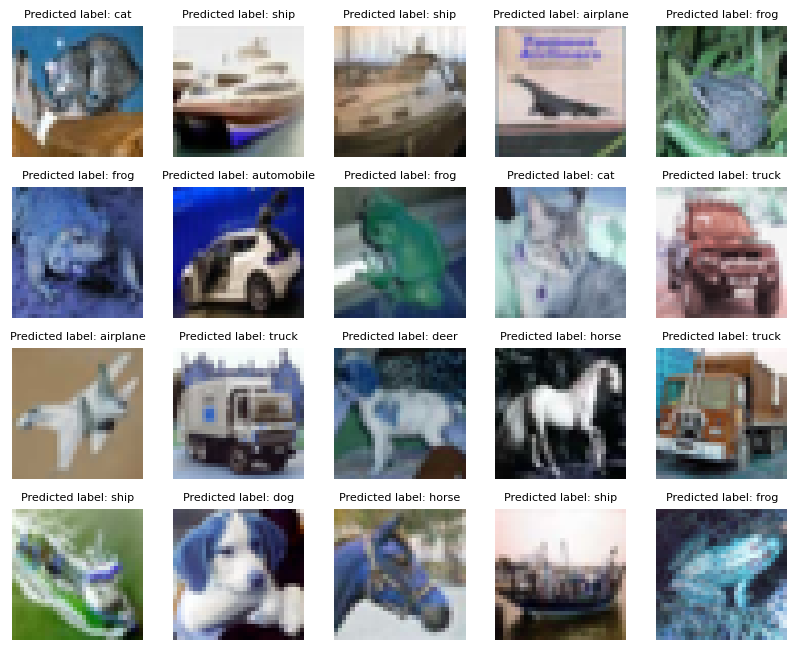

In [24]:
# License 2 (see end of notebook)

# Extract and dump first 20 images 
for i in range(20): 
    im = images[i]
    im  = im.transpose(1,2,0)
    im = cv2.cvtColor(im,cv2.COLOR_RGB2BGR)
    im_name = f'./{dirname}/image_{i}.png'
    cv2.imwrite(im_name, im)

viz_predicted_labels = []
misclassified_images = []
misclassified_labels = []
show_imlist = []

# Pick dumped images and predict
for i in range(20): 
    image_name = f'./{dirname}/image_{i}.png'
    image = Image.open(image_name).convert('RGB')
    # Resize the image to match the input size expected by the model
    image = image.resize((32, 32))  
    image_array = np.array(image).astype(np.float32)
    image_array = image_array/255

    # Reshape the array to match the input shape expected by the model
    image_array = np.transpose(image_array, (2, 0, 1))  

    # Add a batch dimension to the input image
    input_data = np.expand_dims(image_array, axis=0)

    # Run the model
    outputs = session.run(None, {'input': input_data})

    # Process the outputs
    predicted_class = np.argmax(outputs[0])
    predicted_label = metadata['label_names'][predicted_class]
    viz_predicted_labels.append(predicted_class)
    label = metadata['label_names'][labels[i]]
    # print(f'Image {i}: Actual Label {label}, Predicted Label {predicted_label}')
    if (label != predicted_label):
        misclassified_images.append(i)
        misclassified_labels.append(predicted_label)

    show_imlist.append(cv2.cvtColor(images[i].transpose(1,2,0), cv2.COLOR_RGB2BGR))


fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 5),  # creates 4x5 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image, label in zip(grid, show_imlist, viz_predicted_labels):
    ax.axis("off")
    ax.imshow(image)
    ax.set_title(f'Predicted label: {Cifar10Classes(label).name}', fontdict={'fontsize':8})

plt.show()

Display the misclassifications

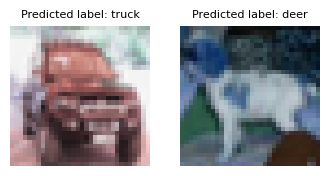

In [10]:
show_imlist_mis = []

for i in misclassified_images:
    show_imlist_mis.append(cv2.cvtColor(images[i].transpose(1,2,0), cv2.COLOR_RGB2BGR))

varpltsize = len(misclassified_images)

fig = plt.figure(figsize=((1 * 2 * varpltsize), 1 * 2 * varpltsize))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, len(misclassified_images)),  
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image, label in zip(grid, show_imlist_mis, misclassified_labels):
    ax.axis("off")
    ax.imshow(image)
    ax.set_title(f'Predicted label: {label}', fontdict={'fontsize':8})

plt.show()

### Inference for more test images

<div class="alert alert-box alert-warning">
<strong>Note:</strong> the cell below may extract up to 5,000 images. You can delete the extracted images by following the instructions in <b>Delete all Extracted Images</b>.
</div>

The first 5,000 images are extracted from the CIFAR-10 test dataset and converted to the .png format.    
The .png images are read, classified and visualized by running the quantized ResNet-50 model on the NPU.

In [11]:
# License 2 (see end of notebook)

max_images = len(images)//2 # 5000 test images

# Extract and dump all images in the test set 
for i in range(max_images): 
    im = images[i]
    im  = im.transpose(1,2,0)
    im = cv2.cvtColor(im,cv2.COLOR_RGB2BGR)
    im_name = f'./{dirname}/image_{i}.png'
    cv2.imwrite(im_name, im)

cm_predicted_labels = []
cm_actual_labels = []

# Pick dumped images and predict
for i in range(max_images): 
    image_name = f'./{dirname}/image_{i}.png'
    try:
        image = Image.open(image_name).convert('RGB')
    except:
        print(f"Warning: Image {image_name} maybe locked moving on to next image")
        continue
    # Resize the image to match the input size expected by the model
    image = image.resize((32, 32))  
    image_array = np.array(image).astype(np.float32)
    image_array = image_array/255

    # Reshape the array to match the input shape expected by the model
    image_array = np.transpose(image_array, (2, 0, 1))  

    # Add a batch dimension to the input image
    input_data = np.expand_dims(image_array, axis=0)

    # Run the model
    outputs = session.run(None, {'input': input_data})

    # Process the outputs
    predicted_class = np.argmax(outputs[0])
    predicted_label = metadata['label_names'][predicted_class]
    cm_predicted_labels.append(predicted_class)
    label = metadata['label_names'][labels[i]]
    cm_actual_labels.append(labels[i])
    if i%990 == 0:
        print(f'Status: Running Inference on image {i}... Actual Label: {label}, Predicted Label: {predicted_label}')


Status: Running Inference on image 0... Actual Label: cat, Predicted Label: cat
Status: Running Inference on image 990... Actual Label: automobile, Predicted Label: automobile
Status: Running Inference on image 1980... Actual Label: truck, Predicted Label: truck
Status: Running Inference on image 2970... Actual Label: dog, Predicted Label: dog
Status: Running Inference on image 3960... Actual Label: bird, Predicted Label: bird
Status: Running Inference on image 4950... Actual Label: bird, Predicted Label: bird


### Confusion matrix

The X-axis represents the predicted class and the Y-axis represents the actual class.

The diagonal cells show true positives, they show how many instances of each class were correctly predicted by the model. 
The off-diagonal cells show instances where the predicted class did not match the actual class.

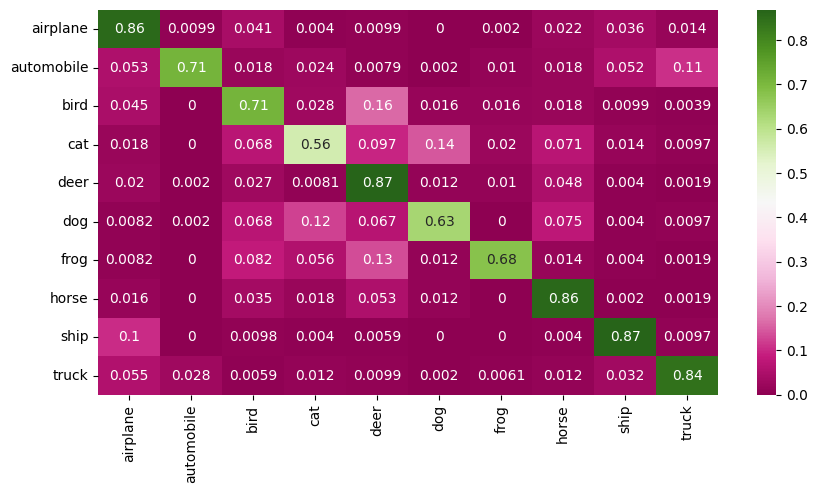

In [12]:
cf_matrix = confusion_matrix(cm_actual_labels, cm_predicted_labels)
df = pd.DataFrame(cf_matrix/np.sum(cf_matrix,axis=1), index = [Cifar10Classes(i).name for i in range(10)], columns=[Cifar10Classes(i).name for i in range(10)])
plt.figure(figsize = (10,5));
sn.heatmap(df, annot=True, cmap="PiYG");

### Accuracy of the quantized model for 5,000 test images

<div class="alert alert-box alert-info">
The below accuracy on the test images is calculated for the quantized model run on the NPU.
</div>

In [13]:
print(f" Accuracy of the quantized model for the test set is : {(accuracy_score(cm_actual_labels, cm_predicted_labels)*100):.2f} %")

 Accuracy of the quantized model for the test set is : 75.86 %


### AI Analyzer
AMD AI Analyzer is a tool that supports analysis and visualization of model compilation and inference on the the Ryzen AI NPU. The primary goal of the tool is to help users better understand how the models are processed by the hardware, and to identify performance bottlenecks that may be present during model inference. Using the AI Analyzer, users can effectively visualize graph and operator partitions between the NPU and CPU.

In [ ]:
!aianalyzer ./ -p 8001

---

## Optional: Deploy the Model on CPU

Deploy the Quantized ONNX Model on CPU (default provider)

In [14]:
providers = ['CPUExecutionProvider']
provider_options = [{}]

session = onnxruntime.InferenceSession(model.SerializeToString(), providers=providers,
                               provider_options=provider_options)

In [15]:
# License 2 (see end of notebook)

#Pick dumped images and predict
for i in range(10): 
    image_name = f'./{dirname}/image_{i}.png'
    image = Image.open(image_name).convert('RGB')
    # Resize the image to match the input size expected by the model
    image = image.resize((32, 32))  
    image_array = np.array(image).astype(np.float32)
    image_array = image_array/255

    # Reshape the array to match the input shape expected by the model
    image_array = np.transpose(image_array, (2, 0, 1))  

    # Add a batch dimension to the input image
    input_data = np.expand_dims(image_array, axis=0)


    # Run the model
    outputs = session.run(None, {'input': input_data})


    # Process the outputs
    predicted_class = np.argmax(outputs[0])
    predicted_label = metadata['label_names'][predicted_class]
    label = metadata['label_names'][labels[i]]
    print(f'Image {i}: Actual Label {label}, Predicted Label: {predicted_label}')


Image 0: Actual Label cat, Predicted Label: cat
Image 1: Actual Label ship, Predicted Label: ship
Image 2: Actual Label ship, Predicted Label: automobile
Image 3: Actual Label airplane, Predicted Label: airplane
Image 4: Actual Label frog, Predicted Label: deer
Image 5: Actual Label frog, Predicted Label: frog
Image 6: Actual Label automobile, Predicted Label: automobile
Image 7: Actual Label frog, Predicted Label: frog
Image 8: Actual Label cat, Predicted Label: dog
Image 9: Actual Label automobile, Predicted Label: truck


----

## Delete all Extracted Images

In [17]:
# Delete all extracted images to save disk space 
images_path = os.path.join(os.getcwd(), "onnx", "onnx_test_images","*")
files = glob.glob(images_path)
for f in files:
    try:
        os.remove(f)
    except:
        continue

----

## Licenses

License 1

```python
# -------------------------------------------------------------------------
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.
# --------------------------------------------------------------------------
```

License 2

```python
#################################################################################  
# License
# Ryzen AI is licensed under `MIT License <https://github.com/amd/ryzen-ai-documentation/blob/main/License>`_ . Refer to the `LICENSE File <https://github.com/amd/ryzen-ai-documentation/blob/main/License>`_ for the full license text and copyright notice.
```

-------------

<center>
Copyright&copy; 2023 AMD, Inc
</center>
<center>
SPDX-License-Identifier: MIT
</center>